# Жаров Всеволод, Младший исследователь данных (DS NLP)

## Импорты библиотек и некоторые глобальные переменные

In [13]:
import pandas as pd
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation as PUNCTUATION
import numpy as np
import matplotlib.pyplot as plt
import re
import youtokentome as yttm
from sklearn.model_selection import train_test_split
import lightning as L

L.seed_everything(1702)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alagril/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Seed set to 1702


1702

In [4]:
MYSTEM = Mystem()

In [5]:
RUSSIAN_STOPWORDS = stopwords.words("russian")
np.array(RUSSIAN_STOPWORDS)

array(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как',
       'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у',
       'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот',
       'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда',
       'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть',
       'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь',
       'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут',
       'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем',
       'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже',
       'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того',
       'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом',
       'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были',
       'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец',
       'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот',
 

In [6]:
PUNCTUATION

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## Загрузка данных и их анализ

In [6]:
filepath = "negative_classification/dataset/ds_nlp.xlsx"

In [7]:
def load_dataset(filename: str) -> (np.array, np.array):
    df = pd.read_excel(
        io=filename,
        header=[0],
        index_col=0
    )
    x, y = df["text"].to_numpy(dtype=str), df["class"].to_numpy(dtype=str)
    return x, y

In [8]:
text, labels = load_dataset(filepath)

In [22]:
print(labels[:10])
print()
print(text[:10])

['Консультация КЦ' 'Компетентность продавцов/ консультантов'
 'Компетентность продавцов/ консультантов'
 'Компетентность продавцов/ консультантов'
 'Компетентность продавцов/ консультантов' 'Консультация КЦ'
 'Компетентность продавцов/ консультантов' 'Электронная очередь'
 'Электронная очередь' 'Компетентность продавцов/ консультантов']

[' негатив к вам и горячей линии которые нафиг не нужны!!! вообще ничего не решают!!!'
 'перестаньте впаривать клиентам дополнительные товары и услуги, надоело стараться любезно от этих приставаний отбиваться. '
 ' продавец предложил наклеить защитную плёнку за 1300 рублей (с учётом скидки). что сложного сказать покупателю сразу честную цену за товар (услугу)? это конечно не много, но очень не приятно!'
 'продавец режил продать нам товар почему то по завышенной цене. '
 'навязанные услуги ( без моего согласия) на сумму 1949 рубле'
 'оператор проигнорировала информацию об ошибке приложения, не исправила контактную информацию в заказе.'
 'сотрудник мало 

In [9]:
unique_labels, count_unique_labels = np.unique(labels, return_counts=True)
print(unique_labels)

print()

label_to_num = dict()
for idx in range(len(unique_labels)):
    label_to_num[unique_labels[idx]] = idx

print(label_to_num)

['Вежливость сотрудников магазина' 'Время ожидания у кассы'
 'Доступность персонала в магазине'
 'Компетентность продавцов/ консультантов' 'Консультация КЦ'
 'Обслуживание на кассе' 'Обслуживание продавцами/ консультантами'
 'Электронная очередь']

{'Вежливость сотрудников магазина': 0, 'Время ожидания у кассы': 1, 'Доступность персонала в магазине': 2, 'Компетентность продавцов/ консультантов': 3, 'Консультация КЦ': 4, 'Обслуживание на кассе': 5, 'Обслуживание продавцами/ консультантами': 6, 'Электронная очередь': 7}


In [16]:
def plot_unique_labels(labels, plot_name = "Распределение уникальных значений"):
    unique_labels, count_unique_labels = np.unique(labels, return_counts=True)
    plt.barh(width = count_unique_labels, y=list(unique_labels))
    plt.title(plot_name)
    plt.show()

In [28]:
count_unique_labels

array([500, 306, 293, 825, 170, 212, 267, 264])

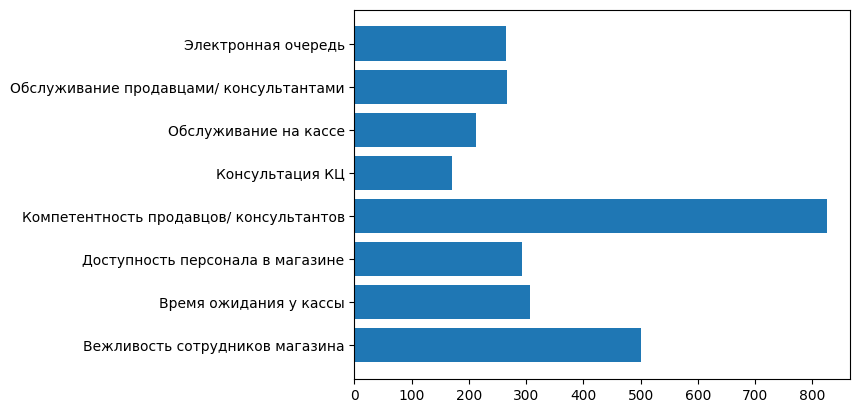

In [35]:
plt.barh(width = count_unique_labels, y=list(unique_labels))
plt.show()

## Предобработка данных

### Очистка данных

In [47]:
def text_lemmatize(text):
    lemma_texts = [MYSTEM.lemmatize(phrase) for phrase in text]
    answer = []
    for phrase in lemma_texts:
        temp_phrase = [token for token in phrase if token not in RUSSIAN_STOPWORDS and token != " " and token.strip() not in PUNCTUATION]
        answer.append(temp_phrase)
    return answer

In [50]:
lemma_texts = text_lemmatize(text)

In [10]:
num_labels = [label_to_num[label] for label in labels]

In [60]:
for i in range(5):
    print(text[i], " -- ", labels[i])
print("-----")
for i in range(5):
    print(lemma_texts[i], " -- ", num_labels[i])

 негатив к вам и горячей линии которые нафиг не нужны!!! вообще ничего не решают!!!  --  Консультация КЦ
перестаньте впаривать клиентам дополнительные товары и услуги, надоело стараться любезно от этих приставаний отбиваться.   --  Компетентность продавцов/ консультантов
 продавец предложил наклеить защитную плёнку за 1300 рублей (с учётом скидки). что сложного сказать покупателю сразу честную цену за товар (услугу)? это конечно не много, но очень не приятно!  --  Компетентность продавцов/ консультантов
продавец режил продать нам товар почему то по завышенной цене.   --  Компетентность продавцов/ консультантов
навязанные услуги ( без моего согласия) на сумму 1949 рубле  --  Компетентность продавцов/ консультантов
-----
['негатив', 'горячий', 'линия', 'который', 'нафиг', 'нужный', '!!!', 'вообще', 'ничто', 'решать', '!!!']  --  4
['переставать', 'впаривать', 'клиент', 'дополнительный', 'товар', 'услуга', 'надоедать', 'стараться', 'любезно', 'приставание', 'отбиваться']  --  3
['продавец

In [93]:
print(lemma_texts[88])

['продавец', 'подходить', 'избегать', 'уметь', 'здороваться', 'красиво', 'стоять', 'кучка', 'приходиться', 'ловить', 'продавец', 'который', 'идти', 'пара', 'ключ', 'машина', 'рука', 'который', 'купить', '😃', 'отличие']


Для очистки отзывов от смайликов и иных мелочей, которые лучше не обрабатывать перед построением словаря, можно воспользоваться регулярным выражением `[а-яА-Я ]+`. В этом случае в тексте отзывов останутся только буквы и пробелы

In [91]:
def for_txt_file(texts, filename):
    file = open(filename, "w")
    for phrase in texts:
        phr = " ".join(phrase)
        phr = re.findall("[а-яА-Я ]+", phr)
        phr = " ".join(phr) + "\n"
        file.write(phr)
    file.close()

In [7]:
filename_lemma = "negative_classification/dataset/neg_text.txt"

In [92]:
for_txt_file(lemma_texts, filename_lemma)

Посмотрим, все ли тексты перекодировались правильны и не исчезли ли какие-то отзывы. В файле их 2837

In [95]:
len(lemma_texts)

2837

Что после лемматизации, что после очистки регулярными выражениями количество отзывов осталось равным 2837. Значит, ничего из них не потерялось, и мы можем в дальнейшем подгружать отзывы из уже предобработанного txt-файла

### Построение словаря с помощью Byte-Pair Encoding

Поскольку у нас задача на специфичную область, то словарь будем строить с помощью мешка n-грамм, реализованного через BPE библиотеки youtokentome. Таким образом для наших конкретных текстов построиться словарь, который будет отражать конкретную специфичную выборку.  
Однако надо подобрать размер словаря, который будет лучше всего аппроксимировать самые частые n-граммы

In [35]:
filename_lemma = "negative_classification/dataset/neg_text.txt"
VOCAB_SIZE = 300
BPE_MODEL_FILENAME = f"negative_classification/models/bpe_{VOCAB_SIZE}.yttm"
#-----
# yttm.BPE.train(data=filename_lemma, vocab_size=VOCAB_SIZE, model=BPE_MODEL_FILENAME)
#-----
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print(" ".join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ а о т н е и р ь с в к д п л з у м ы й я ч б г ж х ц ш щ э ф ю ъ ть ать ▁п ▁с ▁о ка ни то ▁в ▁по ый ро вать ра ▁з ▁м да ер ▁за ин ить та ный ▁н от каз ен ▁к ел но ся ▁про ние од ▁д ва ру ник он ▁вы ри ять ве ▁заказ ▁от во га одить ед ходить ▁ма ▁то руд ча ▁сот ▁сотруд ▁у ▁ра ение ▁сотрудник ол ли ▁выда ▁на ст лу зин ▁мага ▁магазин ывать ▁при ре ▁оч ▁ка тел вар ▁об ла ▁товар ль сс ▁х ▁выдача уп го тель ивать ти ▁прода ▁б ▁и ▁касс ▁э ▁ко ес жд ий чать ко вец ▁продавец ло куп еред ид ▁покуп ма ▁раб тор ир ждать ▁очеред ень ▁очередь ▁ч мо ▁не еть об ле ▁та лять ▁т ▁под ▁полу аться су ▁сто ▁касса ор ент ис ▁во ▁оп ▁пер ▁это ста слу жи ▁приходить ▁ждать ск ет ▁мин ело ▁кон ▁дол ци вый ам сто ▁до казывать она лон ▁мину ▁работ ▁г ▁минута ▁талон атель нный жа ▁очень торый тер влять сть суль ▁который вой ▁консуль про ▁хот ▁сп ▁кли ство ▁консульта ▁ин ▁а ▁покупатель кт казать ▁сказать нт ▁чело ▁со ▁челове ▁получать ▁человек на прос ▁вид ит ина гать ▁работать ▁хам ▁консуль

Тут можно рассмотреть разные размеры словаря, но как будто бы очень большой словарь и не требуется, т.к. слова часто повторяются

In [3]:
def load_text_from_file(filename):
    with open(filename) as f:
        lines = [line[:-1] for line in f.readlines()]
    return lines

In [4]:
lemma_text = load_text_from_file(filename_lemma)

In [11]:
print(len(lemma_text))
print(lemma_text[:5])
print(len(num_labels))
print(num_labels[:5])


2837
['негатив горячий линия который нафиг нужный   вообще ничто решать ', 'переставать впаривать клиент дополнительный товар услуга надоедать стараться любезно приставание отбиваться', 'продавец предлагать наклеивать защитный пленка   рубль учет скидка сложный сказать покупатель сразу честный цена товар услуга это очень приятный', 'продавец реживать продавать товар почему завышать цена', 'навязывать услуга согласие сумма   рубль']
2837
[4, 3, 3, 3, 3]


In [14]:
train_text, val_text, train_labels, val_labels = train_test_split(lemma_text, num_labels, test_size=0.1)

print(len(train_text))
print(len(val_text))

2553
284


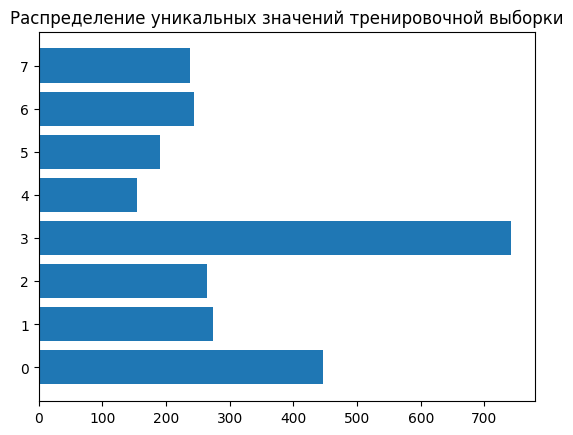

In [17]:
plot_unique_labels(train_labels, plot_name="Распределение уникальных значений тренировочной выборки")

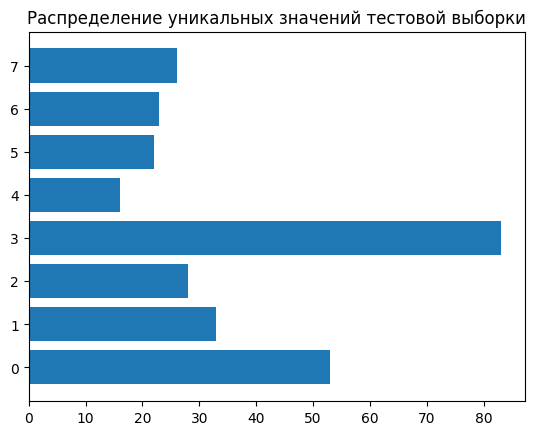

In [18]:
plot_unique_labels(val_labels, plot_name="Распределение уникальных значений тестовой выборки")

In [19]:
train_tokens = tokenizer.encode(train_text, bos=True, eos=True)
val_tokens = tokenizer.encode(val_text, bos=True, eos=True)

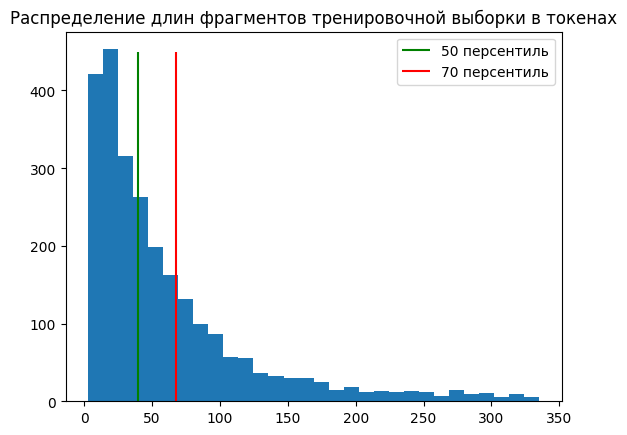

In [36]:
plt.hist([len(sentence) for sentence in train_tokens], bins=30)
plt.vlines([np.percentile([len(sentence) for sentence in train_tokens], 50)], [0], [450], label="50 персентиль", color="green")
plt.vlines([np.percentile([len(sentence) for sentence in train_tokens], 70)], [0], [450], label="70 персентиль", color="red")
plt.title('Распределение длин фрагментов тренировочной выборки в токенах')
plt.legend()
plt.show()

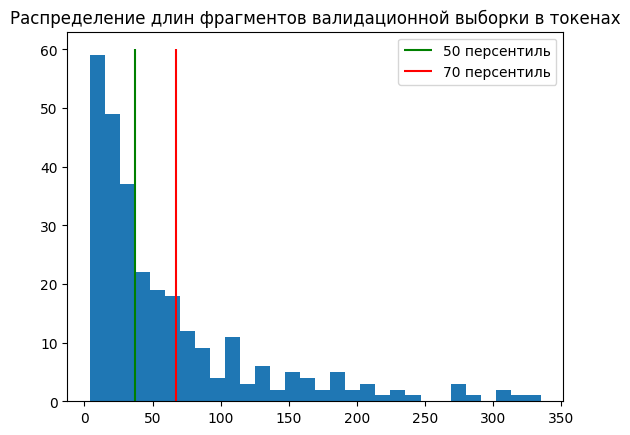

In [37]:
plt.hist([len(sentence) for sentence in val_tokens], bins=30)
plt.vlines([np.percentile([len(sentence) for sentence in val_tokens], 50)], [0], [60], label="50 персентиль", color="green")
plt.vlines([np.percentile([len(sentence) for sentence in val_tokens], 70)], [0], [60], label="70 персентиль", color="red")
plt.title('Распределение длин фрагментов валидационной выборки в токенах')
plt.legend()
plt.show()

Длины отзывов в токенах могут быть совершенно разными, однако для словаря из 300 токенов больше 50% отзывов меньше 50 токенов. 70-персентиль находится примерно на 60 токенах.  
Таким образом, мы будем дополнять отзывы до `60` токенов паддингом, а отзывы, что больше по длине - обрезать. Предполагаем, что основная информация отзыва, по которому можно сделать вывод о том, с какого типа проблемой столкнулся клиент, находится в начале отзыва, а концовка - это подробное объяснение, что именно было не так

## Обучение модели